# Time series analysis for QIN and EEZ, output data for timeseries, pdfs, and thresholds

In [135]:
# import libraries
import numpy as np
import pandas as pd
#import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
import warnings
warnings.simplefilter('ignore') # filter some warning messages

In [136]:
def weighted_mean(data_in,data_cond):
    import numpy as np
    import xarray as xr
    #data_in = input xarray data to have weighted mean
    #data_mask = nan mask eg. land values
    #LME mask T or F values
    global_attrs = data_in.attrs
    R = 6.37e6 #radius of earth in m
    grid_dy,grid_dx = (data_in.lat[0]-data_in.lat[1]).data,(data_in.lon[0]-data_in.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(data_in.lat)) 
    pixel_area = dA.where(data_cond==1)
    sum_data=(data_in*pixel_area).sum(dim=('lon', 'lat'),keep_attrs=True, skipna=True)
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    #print(sum_data)
    #print(total_ocean_area)
    data_weighted_mean = sum_data/total_ocean_area
    data_weighted_mean.attrs = global_attrs  #save global attributes
    for a in data_in:                      #set attributes for each variable in dataset
        gatt = data_in[a].attrs
        data_weighted_mean[a].attrs=gatt

    return data_weighted_mean

# Specify below the variable and location of variable you want to see

In [137]:
#specify variable and location of variable

#variable- 'thetao' 'o2' 
#location of variable- 'surface' 'bottom' 

var='o2'
loc='bottom'
figdir='/Volumes/GoogleDrive/My Drive/QIN/figures/'

#directory for masks
mask_dir ='/Volumes/GoogleDrive/My Drive/QIN/masks/'

svar=loc +" "+ var
if var=='thetao':
    units='°C'
if var=='o2' :
    units='ml/l'
print(svar)

bottom o2


In [138]:
#read observations
import glob
for fn in glob.glob('/Volumes/GoogleDrive/My Drive/QIN/data/GLORYS_timeseries_*'+loc+'_'+var+'*'):
    print  (fn)
    obs=xr.open_dataset(fn)
    obs.close()
obs=obs.sel(lat=slice(31.0 , 48.916668),lon=slice(220.0,244.91666 ))
obs

/Volumes/GoogleDrive/My Drive/QIN/data/GLORYS_timeseries_extrapolated_bottom_o2_216x300.nc


<xarray.Dataset>
Dimensions:  (lat: 216, lon: 300, time: 312)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2018-12-16T12:00:00
  * lat      (lat) float32 31.0 31.08 31.17 31.25 ... 48.67 48.75 48.83 48.92
  * lon      (lon) float32 220.0 220.1 220.2 220.2 ... 244.7 244.8 244.8 244.9
Data variables:
    o2       (time, lat, lon) float64 ...
    depth    (lat, lon) float64 ...
    mask     (lat, lon) int64 ...

In [139]:
fn=mask_dir+'qin_mask.nc'
qin_mask=xr.open_dataset(fn)
qin_mask.close()
qin_mask=qin_mask.polygon_mask
print(qin_mask)

<xarray.DataArray 'polygon_mask' (lat: 216, lon: 300)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lat      (lat) float32 31.0 31.08 31.17 31.25 ... 48.67 48.75 48.83 48.92
  * lon      (lon) float32 220.0 220.1 220.2 220.2 ... 244.7 244.8 244.8 244.9


In [140]:
#read eez mask and check
fn=mask_dir+'eez_mask.nc'
eez_mask=xr.open_dataset(fn)
eez_mask.close()
eez_mask=eez_mask.region_mask.load()

In [141]:
# calculate obs. timeseries
qin_obs= weighted_mean(obs,qin_mask) 
eez_obs = weighted_mean(obs,eez_mask) 

In [142]:
# read model data files and calculate timeseries
import os
fdir='/Volumes/GoogleDrive/My Drive/QIN/data/'+svar+'/ssp585/'
nbr_mdl=0
qin_mdl=[]
eez_mdl=[]
model_name=[]
for filename in os.listdir(fdir):
    fn=fdir+filename
    dt=xr.open_dataset(fn)
    dt.close()
    print(fn)
    if var == 'o2':
        dt=dt.where(dt>=0,0)
    mdl = filename.split('_')[0]
    nbr_mdl+=1
    print('model name:' +mdl)
    print('this is model number: ' +str(nbr_mdl))
    qin= weighted_mean(dt,qin_mask)    
    eez = weighted_mean(dt,eez_mask)
    qin_mdl.append(qin[var])
    eez_mdl.append(eez[var])
    model_name.append(mdl)

/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp585/ACCESS-ESM1-5_r1i1p1f1_ssp585_sd+ba_final_o2_bottom_1_final_subset.nc
model name:ACCESS-ESM1-5
this is model number: 1
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp585/ACCESS-ESM1-5_r2i1p1f1_ssp585_sd+ba_final_o2_bottom_1_final_subset.nc
model name:ACCESS-ESM1-5
this is model number: 2
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp585/CanESM5-CanOE_r2i1p2f1_ssp585_sd+ba_final_o2_bottom_1_final_subset.nc
model name:CanESM5-CanOE
this is model number: 3
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp585/CanESM5-CanOE_r1i1p2f1_ssp585_sd+ba_final_o2_bottom_1_final_subset.nc
model name:CanESM5-CanOE
this is model number: 4
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp585/UKESM1-0-LL_r2i1p1f2_ssp585_sd+ba_final_o2_bottom_1_final_subset.nc
model name:UKESM1-0-LL
this is model number: 5
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp585/UKESM1-0-LL_r1i1p1f2_ssp585_sd+ba_final_o2_bottom_1_final_subset.nc
model

In [143]:
qin_mdl = xr.DataArray(np.array(qin_mdl),                                 
          name=var,             
          coords={'model':model_name,'time':qin_mdl[0].time},    
          dims=('model','time') )
eez_mdl = xr.DataArray(np.array(eez_mdl),                                 
          name=var,             
          coords={'model':model_name,'time':eez_mdl[0].time},    
          dims=('model','time') )
qin_mdl

<xarray.DataArray 'o2' (model: 6, time: 1283)>
array([[3.80373322e+00, 3.80065482e+00, 3.64174556e+00, ...,
        3.33263002e-01, 8.25921732e-01, 1.44837908e+00],
       [2.02658012e+00, 1.97465797e+00, 1.65421047e+00, ...,
        4.07422822e-01, 9.37293408e-01, 1.57909989e+00],
       [3.33449886e+00, 3.21609101e+00, 2.98714984e+00, ...,
        7.05878099e-02, 9.25814211e-01, 2.95133806e+00],
       [2.89941326e+00, 2.99165269e+00, 2.96631016e+00, ...,
        1.93284823e-03, 2.17712592e-01, 1.69240392e+00],
       [2.94519734e+00, 1.81966326e+00, 1.43977782e+00, ...,
        1.82585949e+00, 2.22506953e+00, 1.87946296e+00],
       [2.94992844e+00, 3.22199978e+00, 2.96424192e+00, ...,
        1.28390688e+00, 2.00593917e+00, 2.64802189e+00]])
Coordinates:
  * model    (model) <U13 'ACCESS-ESM1-5' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) datetime64[ns] 1993-02-15 ... 2099-12-16T12:00:00

In [144]:
#calculate annual time series
qin_obs_ann=qin_obs.groupby('time.year').mean('time')
eez_obs_ann=eez_obs.groupby('time.year').mean('time')


qin_mdl_ann=qin_mdl.groupby('time.year').mean('time')
eez_mdl_ann=eez_mdl.groupby('time.year').mean('time')

In [145]:
# read model data files and calculate timeseries
import os
fdir='/Volumes/GoogleDrive/My Drive/QIN/data/'+svar+'/ssp245/'
nbr_mdl_245=0
qin_mdl_245=[]
eez_mdl_245=[]
model_name_245=[]
for filename in os.listdir(fdir):
    fn=fdir+filename
    dt=xr.open_dataset(fn)
    dt.close()
    if var == 'o2':
        dt=dt.where(dt>=0,0)
    print(fn)
    mdl = filename.split('_')[0]
    nbr_mdl_245+=1
    print('model name:' +mdl)
    print('this is model number: ' +str(nbr_mdl_245))
    qin= weighted_mean(dt,qin_mask) 
    eez = weighted_mean(dt,eez_mask)
    qin_mdl_245.append(qin[var])
    eez_mdl_245.append(eez[var])
    model_name_245.append(mdl)

/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp245/ACCESS-ESM1-5_r2i1p1f1_ssp245_sd+ba_final_o2_bottom_1_final_subset.nc
model name:ACCESS-ESM1-5
this is model number: 1
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp245/ACCESS-ESM1-5_r1i1p1f1_ssp245_sd+ba_final_o2_bottom_1_final_subset.nc
model name:ACCESS-ESM1-5
this is model number: 2
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp245/CanESM5-CanOE_r2i1p2f1_ssp245_sd+ba_final_o2_bottom_1_final_subset.nc
model name:CanESM5-CanOE
this is model number: 3
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp245/CanESM5-CanOE_r1i1p2f1_ssp245_sd+ba_final_o2_bottom_1_final_subset.nc
model name:CanESM5-CanOE
this is model number: 4
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp245/UKESM1-0-LL_r2i1p1f2_ssp245_sd+ba_final_o2_bottom_1_final_subset.nc
model name:UKESM1-0-LL
this is model number: 5
/Volumes/GoogleDrive/My Drive/QIN/data/bottom o2/ssp245/UKESM1-0-LL_r1i1p1f2_ssp245_sd+ba_final_o2_bottom_1_final_subset.nc
model

In [146]:
qin_mdl_245 = xr.DataArray(np.array(qin_mdl_245),                                 
          name=var,             
          coords={'model':model_name_245,'time':qin_mdl_245[0].time},    
          dims=('model','time') )

eez_mdl_245 = xr.DataArray(np.array(eez_mdl_245),                                 
          name=var,             
          coords={'model':model_name_245,'time':eez_mdl_245[0].time},    
          dims=('model','time') )
qin_mdl_245

<xarray.DataArray 'o2' (model: 6, time: 1283)>
array([[2.3223588 , 2.27069382, 1.92978752, ..., 1.34693813, 1.75622658,
        2.36824511],
       [4.22935576, 4.23947729, 4.08660435, ..., 0.21804872, 0.89612617,
        1.63503111],
       [3.65563896, 3.50403832, 3.26736599, ..., 1.31379318, 1.68284508,
        2.35885579],
       [3.13710226, 3.2354276 , 3.20610068, ..., 0.1531822 , 0.72372019,
        2.06127735],
       [3.04162178, 1.90608068, 1.53706218, ..., 2.19308014, 2.82226805,
        3.89214632],
       [3.06869954, 3.31507841, 3.05597118, ..., 0.52881779, 1.11559597,
        2.25074473]])
Coordinates:
  * model    (model) <U13 'ACCESS-ESM1-5' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * time     (time) datetime64[ns] 1993-02-15 ... 2099-12-16T12:00:00

In [147]:
qin_mdl.to_netcdf(figdir+svar+'_585_timeseries.nc')  
qin_mdl_245.to_netcdf(figdir+svar+'_245_timeseries.nc')  

In [148]:


qin_mdl_ann_245=qin_mdl_245.groupby('time.year').mean('time')
eez_mdl_ann_245=eez_mdl_245.groupby('time.year').mean('time')



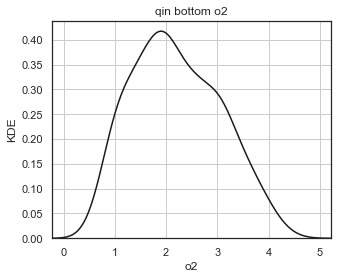

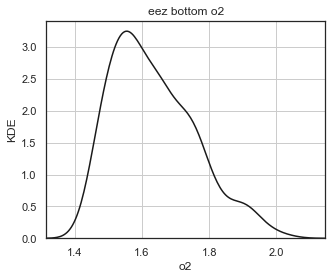

In [149]:
regionlist=["qin","eez"]
p1_s ='1990-01-01'
p1_e='2010-12-31'

p2_s ='2020-01-01'
p2_e='2040-12-31'

p3_s ='2060-01-01'
p3_e='2080-12-31'
#plot observed histogram and get the values
sns.set(style="white", palette="muted", color_codes=True)

obs_x=np.zeros(shape=(len(regionlist),200))
obs_x[:] = np.nan
obs_y=np.zeros(shape=(len(regionlist),200))
obs_y[:] = np.nan
obs_90=np.zeros(shape=(len(regionlist)))
obs_90[:]=np.nan
obs_10=np.copy(obs_90)
i=0
for region in regionlist:
    if region =="qin":
        ts=qin_obs[var]
    if region == "eez":
        ts=eez_obs[var]
    #ts=ts-ts.mean('time')
    plt.figure(figsize=(5,4))
    binw=(ts.max()-ts.min()).values/10
    #print(binw)
    lbl="obs:"+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]
    nbin=np.int((max(ts)-min(ts))/binw)
    fig=sns.distplot(ts, bins=nbin, hist=False, kde_kws={"label": lbl }, color="k")  
    obs_90[i]=np.nanpercentile(ts,90)#ts.quantile(.9)
    obs_10[i]=np.nanpercentile(ts,10)#ts.quantile(.1)

    #getting the curve
    obs_x[i,:], obs_y[i,:] = fig.lines[0].get_data()

    #plt.yticks(fig.get_yticks(), (fig.get_yticks() * binw *100).round(0))
    plt.grid(True)
    plt.ylabel('KDE')
    plt.title(region+' '+svar)
    plt.autoscale(enable=True, axis='x', tight=True)

    plt.show()
    i+=1

In [150]:
obs_10,obs_90

(array([1.10038505, 1.4917759 ]), array([3.37198524, 1.79762492]))

qin


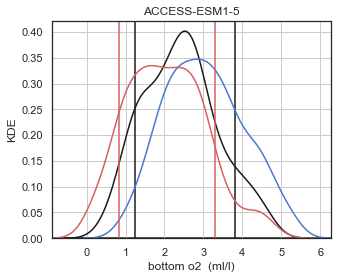

model no.1


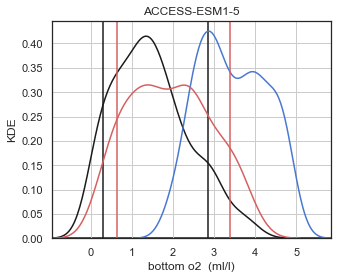

model no.2


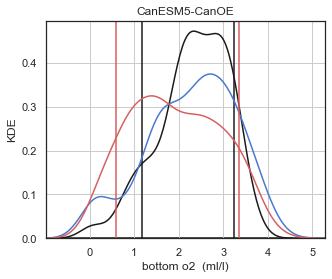

model no.3


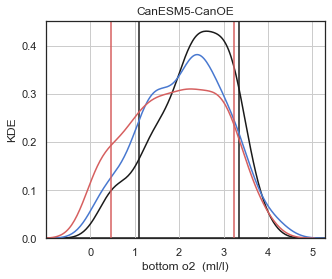

model no.4


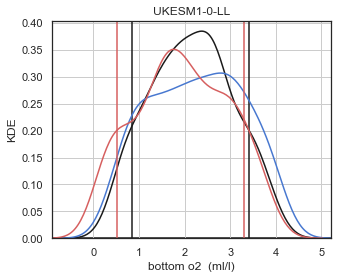

model no.5


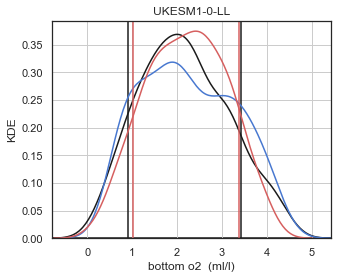

model no.6
eez


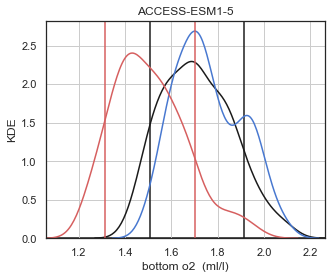

model no.1


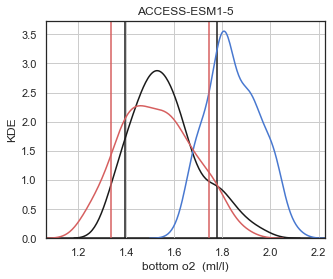

model no.2


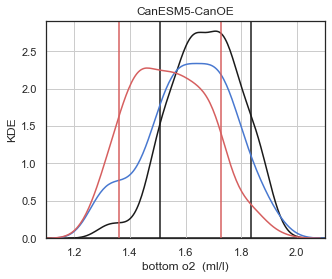

model no.3


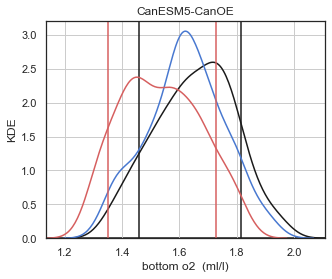

model no.4


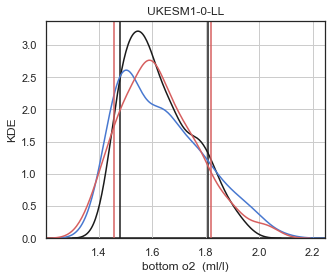

model no.5


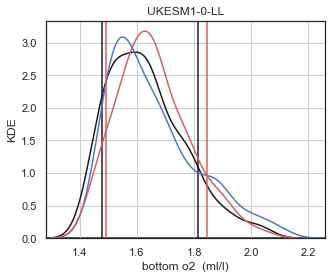

model no.6


In [151]:
# calculate model PDFs and ensemble them
p1_s ='1990-01-01'
p1_e='2010-12-31'

p2_s ='2020-01-01'
p2_e='2040-12-31'

p3_s ='2060-01-01'
p3_e='2080-12-31'

p1_x=np.zeros(shape=(len(regionlist),nbr_mdl,200))
p1_x[:] = np.nan
p1_y=np.copy(p1_x)
p2_x=np.copy(p1_x)
p2_y=np.copy(p1_x)
p3_x=np.copy(p1_x)
p3_y=np.copy(p1_x)

p1_90=np.zeros(shape=(len(regionlist),nbr_mdl))
p1_90[:]=np.nan
p1_10=np.copy(p1_90)
p3_90=np.copy(p1_90)
p3_10=np.copy(p1_90)

k=0
for region in regionlist:
    if region =="qin":
        Target=qin_mdl
    if region == "eez":
        Target=eez_mdl  
        
    p1=Target.sel(time=slice(p1_s , p1_e))
    p2=Target.sel(time=slice(p2_s , p2_e))
    p3=Target.sel(time=slice(p3_s , p3_e))
    #clim=p1.mean('time')
    #p1=p1-clim
    #p2=p2-clim
    #p3=p3-clim
    
    print(region) 
    for i in range (nbr_mdl):
        mdl=str(Target.model[i].values)
        sns.set(style="white", palette="muted", color_codes=True)

        # Plot a PDF (kernel density estimate ) plot

        plt.figure(figsize=(5,4))

        minn=np.min([p1[i].min(),p2[i].min(),p3[i].min()])
        maxx=np.max([p1[i].max(),p2[i].max(),p3[i].max()])
        binw=(maxx-minn)/10

        #PERIOD 1
        TS=p1[i]
        lbl=mdl+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        sns.distplot(TS, bins=nbin, hist=False,kde_kws={"label": lbl}, color="k") 
        p1_90[k,i]=TS.quantile(.9)
        p1_10[k,i]=TS.quantile(.1)
        plt.axvline(x=p1_90[k,i], color="k")
        plt.axvline(x=p1_10[k,i], color="k")
        #PERIOD 2
        TS=p2[i]
        lbl=mdl+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="b")  #, ax=axes[0, 0])

        #PERIOD 3
        TS=p3[i]
        lbl=mdl+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="r")  #, ax=axes[0, 0])
        p3_90[k,i]=TS.quantile(.9)
        p3_10[k,i]=TS.quantile(.1)
        plt.axvline(x=p3_90[k,i], color="r")
        plt.axvline(x=p3_10[k,i], color="r")
        
        p1_x[k,i,:], p1_y[k,i,:] = fig.lines[0].get_data()
        p2_x[k,i,:], p2_y[k,i,:] = fig.lines[3].get_data()
        p3_x[k,i,:], p3_y[k,i,:] = fig.lines[4].get_data()
        #print(data_x.shape, data_y.shape )
        #plt.yticks(fig.get_yticks(), (fig.get_yticks() * binw *100).round(0))
        plt.grid(True)
        plt.axhline(color='k',zorder=0)
        plt.ylabel('KDE')
        plt.xlabel(svar+  '  ('+units+')')
        plt.title(mdl)
        plt.autoscale(enable=True, axis='x', tight=True)

        plt.show()
        print('model no.' +str(i+1)) 
    k+=1

In [152]:
#interpolate individual pdfs for ensemble
N=200
y1 = np.zeros(shape=(len(regionlist),nbr_mdl,N))
y1[:] = np.nan
y2 = np.copy(y1)
y3 = np.copy(y1)
p1_mean_x = np.zeros(shape=(len(regionlist),N))
p1_mean_x[:] = np.nan
p2_mean_x = np.copy(p1_mean_x)
p3_mean_x = np.copy(p1_mean_x)

for k in range (len(regionlist)):
    
    xmin=np.nanmin([obs_x[k,:].min(),p1_x[k,:,:].min(),p2_x[k,:,:].min(),p3_x[k,:,:].min()])
    xmax=np.nanmax([obs_x[k,:].max(),p1_x[k,:,:].max(),p2_x[k,:,:].max(),p3_x[k,:,:].max()])

    xi = np.linspace(xmin, xmax, num=N)
    print(xmin,xmax)
    
    for i in range (nbr_mdl):
        y1[k,i,:] = np.interp(xi,p1_x[k,i,:], p1_y[k,i,:])
        y2[k,i,:] = np.interp(xi,p2_x[k,i,:], p2_y[k,i,:])
        y3[k,i,:] = np.interp(xi,p3_x[k,i,:], p3_y[k,i,:])

    p1_mean_x[k,:] =xi
    p2_mean_x[k,:] =xi
    p3_mean_x[k,:] =xi

y1= xr.DataArray(y1,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y2= xr.DataArray(y2,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y3= xr.DataArray(y3,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
#print(y3)
#UKESM1 LE
p1_le_y=y1.sel(model='UKESM1-0-LL').mean('model')
p2_le_y=y2.sel(model='UKESM1-0-LL').mean('model')
p3_le_y=y3.sel(model='UKESM1-0-LL').mean('model')
#MME
#NN=nbr_mdl-len(y1.sel(model='UKESM1-0-LL').model)+1
p1_mme_y=y1.mean('model')#[:,0:NN,:].mean('model')
p2_mme_y=y2.mean('model')#[:,0:NN,:].mean('model')
p3_mme_y=y3.mean('model')#[:,0:NN,:].mean('model')

#print(p3_le_y)

obs_interp_y=np.zeros(shape=(len(regionlist),N))
obs_interp_y[:] = np.nan
obs_interp_x=np.copy(obs_interp_y)
for k in range (len(regionlist)):
    xi = p1_mean_x[k,:]
    obs_interp_y[k,:] = np.interp(xi,obs_x[k,:], obs_y[k,:]) 
    obs_interp_x[k,:] = xi

-0.9962450062461993 6.2806261692537495
1.0584295670110824 2.2634540380927253


In [153]:
p1_90_mme=np.mean(p1_90,axis=1)
p1_10_mme=np.mean(p1_10,axis=1)
p3_90_mme=np.mean(p3_90,axis=1)
p3_10_mme=np.mean(p3_10,axis=1)

qin


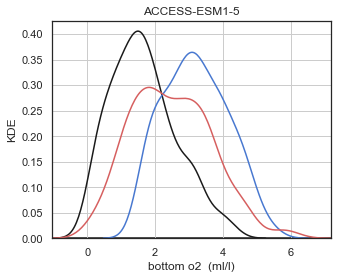

model no.1


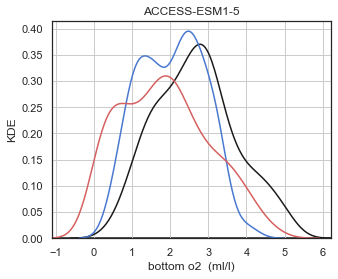

model no.2


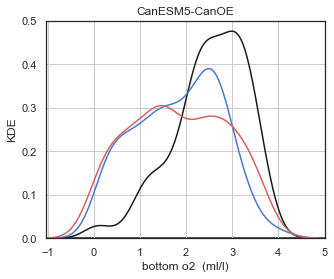

model no.3


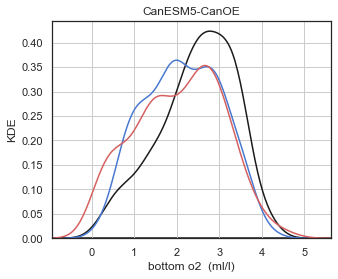

model no.4


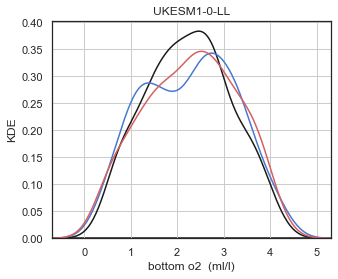

model no.5


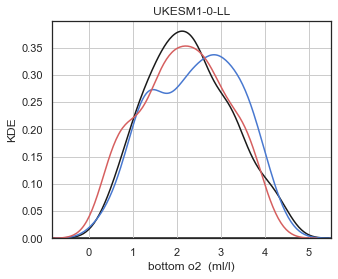

model no.6
eez


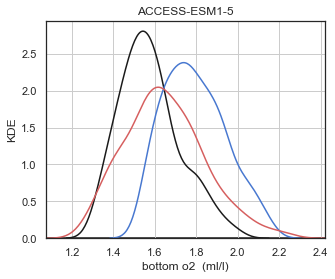

model no.1


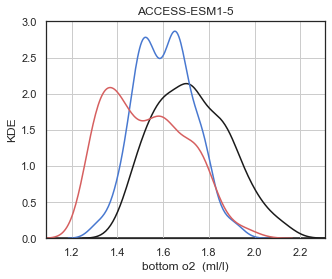

model no.2


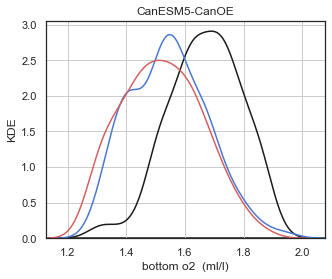

model no.3


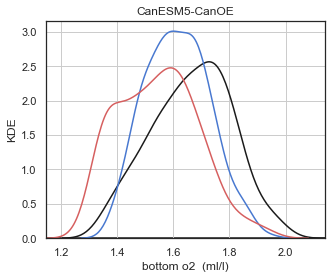

model no.4


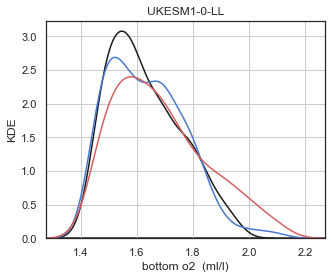

model no.5


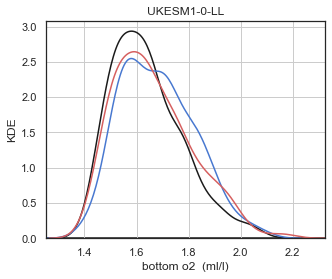

model no.6


In [154]:
# calculate model PDFs and ensemble them

p1_s ='1990-01-01'
p1_e='2010-12-31'

p2_s ='2020-01-01'
p2_e='2040-12-31'

p3_s ='2060-01-01'
p3_e='2080-12-31'
#N=200
p1_x_245=np.zeros(shape=(len(regionlist),nbr_mdl_245,N))
p1_x_245[:] = np.nan
p1_y_245=np.copy(p1_x_245)
p2_x_245=np.copy(p1_x_245)
p2_y_245=np.copy(p1_x_245)
p3_x_245=np.copy(p1_x_245)
p3_y_245=np.copy(p1_x_245)

p1_90_245=np.zeros(shape=(len(regionlist),nbr_mdl_245))
p1_90_245[:]=np.nan
p1_10_245=np.copy(p1_90_245)
p3_90_245=np.copy(p1_90_245)
p3_10_245=np.copy(p1_90_245)

k=0
for region in regionlist:
    if region =="qin":
        Target=qin_mdl_245
    if region == "eez":
        Target=eez_mdl_245 
        
    p1=Target.sel(time=slice(p1_s , p1_e))
    p2=Target.sel(time=slice(p2_s , p2_e))
    p3=Target.sel(time=slice(p3_s , p3_e))
    
    print(region) 
    for i in range (nbr_mdl_245):
        mdl=str(Target.model[i].values)
        sns.set(style="white", palette="muted", color_codes=True)

        # Plot a PDF (kernel density estimate ) plot

        plt.figure(figsize=(5,4))

        minn=np.min([p1[i].min(),p2[i].min(),p3[i].min()])
        maxx=np.max([p1[i].max(),p2[i].max(),p3[i].max()])
        binw=(maxx-minn)/10

        #PERIOD 1
        TS=p1[i]
        lbl=mdl+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        sns.distplot(TS, bins=nbin, hist=False,kde_kws={"label": lbl}, color="k") 
        p1_90_245[k,i]=TS.quantile(.9)
        p1_10_245[k,i]=TS.quantile(.1)
        #PERIOD 2
        TS=p2[i]
        lbl=mdl+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="b")  #, ax=axes[0, 0])

        #PERIOD 3
        TS=p3[i]
        lbl=mdl+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
        nbin=np.int((TS.max()-TS.min())/binw)
        fig=sns.distplot(TS, bins=nbin, hist=False, kde_kws={"label": lbl}, color="r")  #, ax=axes[0, 0])
        p3_90_245[k,i]=TS.quantile(.9)
        p3_10_245[k,i]=TS.quantile(.1)
        p1_x_245[k,i,:], p1_y_245[k,i,:] = fig.lines[0].get_data()
        p2_x_245[k,i,:], p2_y_245[k,i,:] = fig.lines[1].get_data()
        p3_x_245[k,i,:], p3_y_245[k,i,:] = fig.lines[2].get_data()
        #print(data_x.shape, data_y.shape )
        #plt.yticks(fig.get_yticks(), (fig.get_yticks() * binw *100).round(0))
        plt.grid(True)
        plt.axhline(color='k',zorder=0)
        plt.ylabel('KDE')
        plt.xlabel(svar+  '  ('+units+')')
        plt.title(mdl)
        plt.autoscale(enable=True, axis='x', tight=True)

        plt.show()
        print('model no.' +str(i+1)) 
    k+=1

In [155]:
#interpolate individual pdfs for ensemble
N=200
y1 = np.zeros(shape=(len(regionlist),nbr_mdl_245,N))
y1[:] = np.nan
y2 = np.copy(y1)
y3 = np.copy(y1)
p1_mean_x_245 = np.zeros(shape=(len(regionlist),N))
p1_mean_x_245[:] = np.nan
p2_mean_x_245 = np.copy(p1_mean_x_245)
p3_mean_x_245 = np.copy(p1_mean_x_245)

for k in range (len(regionlist)):
    
    xmin=np.nanmin([obs_x[k,:].min(),p1_x_245[k,:,:].min(),p3_x_245[k,:,:].min()])
    xmax=np.nanmax([obs_x[k,:].max(),p1_x_245[k,:,:].max(),p3_x_245[k,:,:].max()])

    xi = np.linspace(xmin, xmax, num=N)
    print(xmin,xmax)
    
    for i in range (nbr_mdl_245):
        y1[k,i,:] = np.interp(xi,p1_x_245[k,i,:], p1_y_245[k,i,:])
        y2[k,i,:] = np.interp(xi,p2_x_245[k,i,:], p2_y_245[k,i,:])
        y3[k,i,:] = np.interp(xi,p3_x_245[k,i,:], p3_y_245[k,i,:])

    p1_mean_x_245[k,:] =xi
    p2_mean_x_245[k,:] =xi
    p3_mean_x_245[k,:] =xi

y1= xr.DataArray(y1,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name_245,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y2= xr.DataArray(y2,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name_245,'interval':range(1,N+1)},    
          dims=('region','model','interval') )
y3= xr.DataArray(y3,                                 
          name=var,             
          coords={'region': regionlist,'model':model_name_245,'interval':range(1,N+1)},    
          dims=('region','model','interval') )

#MME
#NN=nbr_mdl-len(y1.sel(model='UKESM1-0-LL').model)+1
p1_mme_y_245=y1.mean('model')#[:,0:NN,:].mean('model')
p2_mme_y_245=y2.mean('model')#[:,0:NN,:].mean('model')
p3_mme_y_245=y3.mean('model')#[:,0:NN,:].mean('model')



-1.0888445552446997 7.190756281652028
1.0747705989410667 2.4211921301402293


In [156]:
p1_90_mme_245=np.mean(p1_90_245,axis=1)
p1_10_mme_245=np.mean(p1_10_245,axis=1)
p3_90_mme_245=np.mean(p3_90_245,axis=1)
p3_10_mme_245=np.mean(p3_10_245,axis=1)
p3_10_mme_245

array([0.66298716, 1.39890371])

In [157]:
df = pd.DataFrame({'obs_x':obs_interp_x[0,:],'obs_y':obs_interp_y[0,:],
                  'p1_x_245':p1_mean_x_245[0,:],'p1_y_245':p1_mme_y_245[0,:],
                  'p2_x_245':p3_mean_x_245[0,:],'p2_y_245':p3_mme_y_245[0,:],
                  'p1_x_585':p1_mean_x[0,:],'p1_y_585':p1_mme_y[0,:],
                  'p2_x_585':p3_mean_x[0,:],'p2_y_585':p3_mme_y[0,:]})
df.to_excel(figdir+svar+'_pdf.xlsx')  

In [158]:
df = pd.DataFrame({'obs_90':obs_90[0],'obs_10':obs_10[0],
                  'p1_90_245':p1_90_mme_245[0],'p1_10_245':p1_10_mme_245[0],
                  'p2_90_245':p3_90_mme_245[0],'p2_10_245':p3_10_mme_245[0],
                  'p1_90_585':p1_90_mme[0],'p1_10_585':p1_10_mme[0],
                  'p2_90_585':p3_90_mme[0],'p2_10_585':p3_10_mme[0]},index=range(1))
df.to_excel(figdir+svar+'_thresholds.xlsx')  

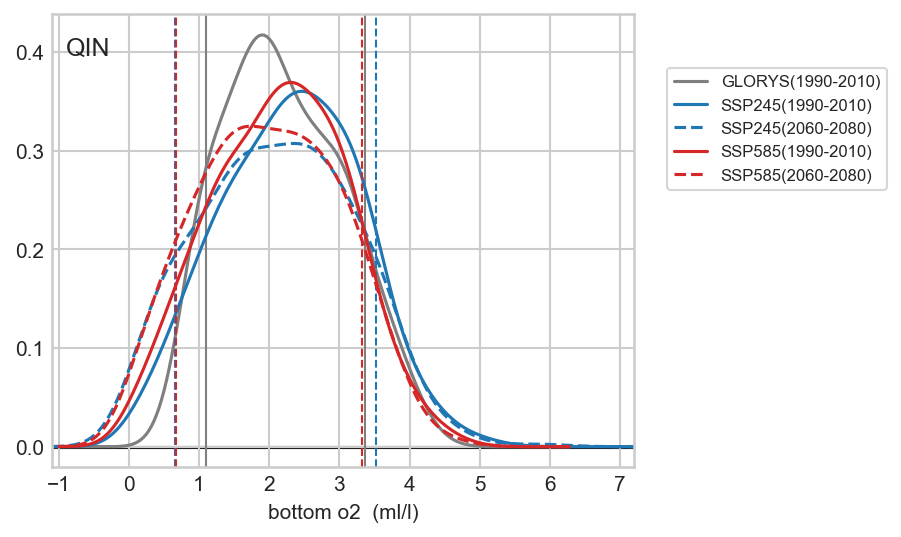

In [159]:
#sns.set(style="white", palette="muted", color_codes=True)
sns.set(style="whitegrid",palette="tab10")
regionlist=["qin"]#,"eez"]
#for thetao
colors = [plt.cm.tab10(0),plt.cm.tab20(1),plt.cm.tab10(3),
          plt.cm.tab20(7),plt.cm.tab10(7)]
#for o2
#colors = [plt.cm.tab10(9),plt.cm.tab20(17),plt.cm.tab10(1),
#         plt.cm.tab20(3),plt.cm.tab10(7)]

from matplotlib import gridspec

fig=plt.figure(figsize=(7,4),dpi=150)
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) 
gs.update(wspace=0.1, hspace=0.17) 


k=0
for region in regionlist:

    ax = plt.subplot(gs[k])
    #obs
    lbl='GLORYS'+"("+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
    ax.plot(obs_interp_x[k,:], obs_interp_y[k,:],color=colors[4],label=lbl)    
    
    plt.axvline(x=obs_90[k],color=colors[4],linewidth=1)#,linestyle='dashed')
    plt.axvline(x=obs_10[k],color=colors[4],linewidth=1)#,linestyle='dashed')
    
    #PERIOD 1
    lbl='SSP245'+"("+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
    ax.plot(p1_mean_x_245[k,:], p1_mme_y_245[k,:],color=colors[0],label=lbl)
    ##PERIOD 2
    #lbl='SSP245'+"("+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
    #ax.plot(p2_mean_x_245[k,:], p2_mme_y_245[k,:],color='b',label=lbl)
    #PERIOD 3
    lbl='SSP245'+"("+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
    ax.plot(p3_mean_x_245[k,:], p3_mme_y_245[k,:],color=colors[0],label=lbl,linestyle='dashed')
    
    plt.axvline(x=p3_90_mme_245[k],color=colors[0],linewidth=1,linestyle='dashed')
    plt.axvline(x=p3_10_mme_245[k],color=colors[0],linewidth=1,linestyle='dashed')

    #PERIOD 1
    lbl='SSP585'+"("+p1_s.split("-")[0]+"-"+p1_e.split("-")[0]+")"
    ax.plot(p1_mean_x[k,:], p1_mme_y[k,:],color=colors[2],label=lbl)
    ##PERIOD 2
    #lbl='SSP585'+"("+p2_s.split("-")[0]+"-"+p2_e.split("-")[0]+")"
    #ax.plot(p2_mean_x[k,:], p2_mme_y[k,:],color='r',label=lbl)
    #PERIOD 3
    lbl='SSP585'+"("+p3_s.split("-")[0]+"-"+p3_e.split("-")[0]+")"
    ax.plot(p3_mean_x[k,:], p3_mme_y[k,:],color=colors[2],label=lbl,linestyle='dashed')
    
    plt.axvline(x=p3_90_mme[k],color=colors[2],linewidth=1,linestyle='dashed')
    plt.axvline(x=p3_10_mme[k],color=colors[2],linewidth=1,linestyle='dashed')   

    plt.grid(True)
    plt.axhline(color='k',zorder=0)
    plt.xlabel(svar+  '  ('+units+')',fontsize=10)
    up=np.max([obs_interp_y[k,:],p1_mme_y[k,:],p2_mme_y[k,:],p3_mme_y[k,:]])
    left=np.min([obs_interp_x[k,:],p3_mean_x[k,:]])
    
    plt.text(left+0.1, up*.95,region.upper())
                  # bbox=dict(  #boxstyle="round",
                  # ec=(1., 0.5, 0.5),
                  # fc=(1., 0.8, 0.8)))
    plt.autoscale(enable=True, axis='x', tight=True)
    ax.tick_params(axis='both', which='major', pad=-2,labelsize=10)
    #ax.set_ylim(0,np.max([obs_interp_y[k,:],p1_mme_y[0,:],p2_mme_y[k,:],p3_mme_y[k,:]])*1.1)
    #plt.yticks([])
    if k==0:
        plt.legend(fontsize=8,loc='upper right', bbox_to_anchor=(1.45, .9))#,ncol=2)

    k+=1

#plt.savefig(figdir+svar+'_pdf_lines.png',dpi=300, bbox_inches = "tight")
plt.tight_layout()
plt.show()